In [1]:
import os,zipfile
os.getcwd()

'/home/roshanbtech/Deep_Learning/CNN_patchers'

In [2]:
# with zipfile.ZipFile('/home/roshanbtech/Deep_Learning/CNN_patchers/global-wheat-detection.zip', 'r') as zip_ref:
#     zip_ref.extractall('/home/roshanbtech/Deep_Learning/CNN_patchers')

In [3]:
import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import glob 
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

In [4]:
train = pd.read_csv('train.csv')
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [5]:
train['bbox'][0]

'[834.0, 222.0, 56.0, 36.0]'

In [6]:
train['bbox'].apply(lambda x: x[1:-1].split(","))

0          [834.0,  222.0,  56.0,  36.0]
1         [226.0,  548.0,  130.0,  58.0]
2         [377.0,  504.0,  74.0,  160.0]
3         [834.0,  95.0,  109.0,  107.0]
4         [26.0,  144.0,  124.0,  117.0]
                       ...              
147788      [64.0,  619.0,  84.0,  95.0]
147789    [292.0,  549.0,  107.0,  82.0]
147790    [134.0,  228.0,  141.0,  71.0]
147791     [430.0,  13.0,  184.0,  79.0]
147792     [875.0,  740.0,  94.0,  61.0]
Name: bbox, Length: 147793, dtype: object

In [7]:
train['bbox'] = train['bbox'].apply(lambda x: x[1:-1].split(","))

In [8]:
train['bbox'][0]

['834.0', ' 222.0', ' 56.0', ' 36.0']

In [9]:
train['x_min'] = train['bbox'].apply(lambda x : x[0]).astype(float)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   image_id  147793 non-null  object 
 1   width     147793 non-null  int64  
 2   height    147793 non-null  int64  
 3   bbox      147793 non-null  object 
 4   source    147793 non-null  object 
 5   x_min     147793 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.8+ MB


In [11]:
train['y_min'] = train['bbox'].apply(lambda x : x[1]).astype(float)
train['width'] = train['bbox'].apply(lambda x : x[2]).astype(float)
train['height'] = train['bbox'].apply(lambda x : x[3]).astype(float)

In [12]:
train.head()

,image_id,width,height,bbox,source,x_min,y_min
0,b6ab77fd7,56.0,36.0,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0
1,b6ab77fd7,130.0,58.0,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0
2,b6ab77fd7,74.0,160.0,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0
3,b6ab77fd7,109.0,107.0,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0
4,b6ab77fd7,124.0,117.0,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0


In [13]:
train['source'].unique()

array(['usask_1', 'arvalis_1', 'inrae_1', 'ethz_1', 'arvalis_3', 'rres_1',
       'arvalis_2'], dtype=object)

In [14]:
train.drop('source',1,inplace = True)

In [15]:
train.drop('bbox',1,inplace =True)

In [16]:
train = train[['image_id','x_min','y_min','width','height']]

In [17]:
train.head(2)

,image_id,x_min,y_min,width,height
0,b6ab77fd7,834.0,222.0,56.0,36.0
1,b6ab77fd7,226.0,548.0,130.0,58.0


In [18]:
train_new = train[train['image_id'] == 'b6ab77fd7']

In [19]:
train_new.head(2)

,image_id,x_min,y_min,width,height
0,b6ab77fd7,834.0,222.0,56.0,36.0
1,b6ab77fd7,226.0,548.0,130.0,58.0


In [20]:
image_id= 'b6ab77fd7'

In [21]:
coco_boxes = train_new[train_new['image_id'] == image_id][['x_min', 'y_min', 'width', 'height']].astype(np.int32).values

In [22]:
coco_boxes

array([[834, 222,  56,  36],
       [226, 548, 130,  58],
       [377, 504,  74, 160],
       [834,  95, 109, 107],
       [ 26, 144, 124, 117],
       [569, 382, 119, 111],
       [ 52, 602,  82,  45],
       [627, 302, 122,  75],
       [412, 367,  68,  82],
       [953, 220,  56, 103],
       [ 30,  70, 126, 133],
       [ 35, 541,  46,  46],
       [103,  60, 117,  83],
       [417,   4, 110,  91],
       [764, 299, 119,  93],
       [539,  58,  58, 130],
       [139, 274, 121,  76],
       [461, 634, 118,  64],
       [215, 634, 113,  75],
       [134, 903, 127,  49],
       [737, 545,  87,  48],
       [292, 930,  43,  46],
       [  0, 827,  86,  58],
       [324,  44,  57,  70],
       [663, 794, 116,  64],
       [325, 730,  76,  72],
       [155, 554,  74,  70],
       [783, 833,  70,  91],
       [534,  46,  73, 224],
       [155, 281, 106, 138],
       [101, 240,  82,  75],
       [583, 329,  80,  83],
       [ 36, 595,  92,  41],
       [  0, 487,  46,  71],
       [ 25, 4

In [23]:
from keras_preprocessing.image import load_img, img_to_array , array_to_img

In [24]:

img = load_img('/home/roshanbtech/Deep_Learning/CNN_patchers/train/'+ image_id +'.jpg')
img_array = img_to_array(img)
img_array /= 255

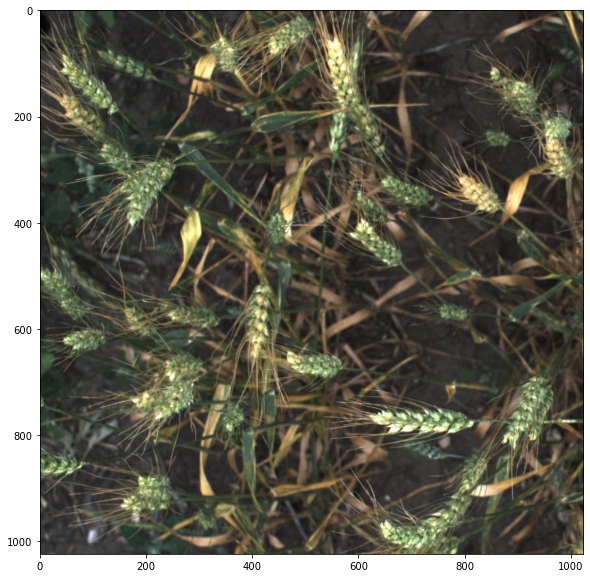

In [25]:
plt.figure(figsize = (10,10))
plt.imshow(img_array)


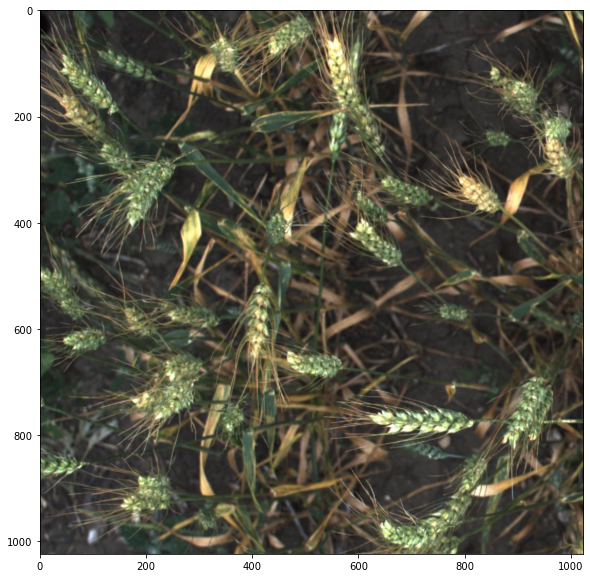

In [26]:
image_id = 'b6ab77fd7'
BASE_DIR = '/home/roshanbtech/Deep_Learning/CNN_patchers'
image = cv2.imread(os.path.join(BASE_DIR, 'train', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
plt.figure(figsize = (10, 10))
plt.imshow(image)
plt.show()

In [27]:
type(img_array)

numpy.ndarray

In [28]:
def get_bbox(bboxes,col, color='white', bbox_format='coco'):
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2], 
                bboxes[i][3], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

In [29]:
# !pip install albumentations
# !pip install torch
# !pip install torchvision

In [30]:
import matplotlib.pyplot as plt
import  matplotlib.patches as patches
import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

In [31]:
aug = albumentations.Compose([
        albumentations.Resize(512, 512),   # Resize the given 1024 x 1024 image to 512 * 512
        albumentations.VerticalFlip(1),     # Verticlly flip the image
        albumentations.Blur(p=1)
    ], bbox_params={'format': 'coco', 'label_fields': ['labels']})

In [32]:
labels = np.ones((len(coco_boxes), ))

In [33]:

aug_result = aug(image=image, bboxes=coco_boxes, labels=labels)

In [34]:
aug_result['image']

array([[[0.22677071, 0.22677071, 0.22677071],
        [0.2255302 , 0.2255302 , 0.2255302 ],
        [0.22394958, 0.22394958, 0.22394958],
        ...,
        [0.72058827, 0.65972394, 0.46782714],
        [0.7263305 , 0.6638256 , 0.46914768],
        [0.7193478 , 0.65624255, 0.4606843 ]],

       [[0.22719088, 0.22719088, 0.22719088],
        [0.22615047, 0.22615047, 0.22615047],
        [0.22458984, 0.22458984, 0.22458984],
        ...,
        [0.7121249 , 0.6534614 , 0.46210486],
        [0.71836734, 0.65812325, 0.46376553],
        [0.7122049 , 0.65134054, 0.4560024 ]],

       [[0.22895159, 0.22895159, 0.22895159],
        [0.2279712 , 0.2279712 , 0.2279712 ],
        [0.22619048, 0.22619048, 0.22619048],
        ...,
        [0.6814526 , 0.6287515 , 0.43989596],
        [0.68803525, 0.6338736 , 0.4419968 ],
        [0.6837335 , 0.62881154, 0.4359344 ]],

       ...,

       [[0.10554222, 0.09769908, 0.10162065],
        [0.10576231, 0.09791917, 0.10184074],
        [0.10902362, 0

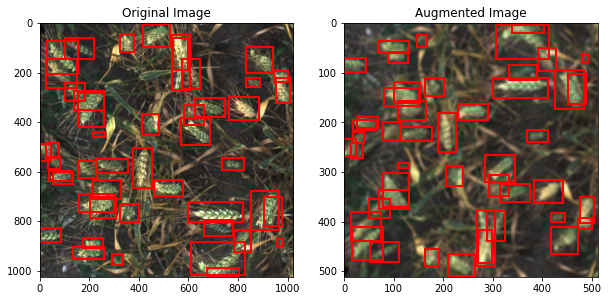

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
get_bbox(coco_boxes, ax[0], color='red', bbox_format='coco')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red', bbox_format='coco')
ax[1].title.set_text('Augmented Image')
ax[1].imshow(aug_result['image'])
plt.show()
